In [ ]:
from huggingface_hub.hf_api import HfFolder
HfFolder.save_token("")

In [ ]:
#!pip install git+https://github.com/huggingface/accelerate.git
#!pip install git+https://github.com/huggingface/transformers.git
!pip install -U bitsandbytes
!pip install sentencepiece
!pip install transformers
!pip install accelerate

In [ ]:
!pip install --upgrade bitsandbytes

In [ ]:
from transformers import LlamaForCausalLM, LlamaTokenizer, AutoTokenizer, set_seed
from transformers import BitsAndBytesConfig
import torch

set_seed(42)

# Load model in 4-bit mode to save VRAM
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)

tokenizer_chat = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
model_chat = LlamaForCausalLM.from_pretrained(
"meta-llama/Llama-2-7b-chat-hf",
quantization_config=bnb_config,
#device_map="auto",
torch_dtype=torch.float16
)

tokenizer_base = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
model_base = LlamaForCausalLM.from_pretrained(
"meta-llama/Llama-2-7b-hf",
quantization_config=bnb_config,
#device_map="auto",
torch_dtype=torch.float16
)

Condition 4: There is an urn that contains 10 balls of two different colors, red and blue. You draw 2 balls and observe 0 of them are red. You put all balls back to the urn. 
Sentence: You are going to draw another ball out of this urn. Under this condition in your opinion the next ball will possibly be red.

In [ ]:
# low and high uncertainty conditions
low = [(10, 0), (8, 2), (9, 3), (8, 4), (9, 6), (8, 6), (10, 10)]
high = [(2, 0), (4, 1), (3, 1), (4, 2), (3, 2), (4, 3), (2, 2)]
inst_b, inst_e = "[INST]", "[/INST]" 
sys_b, sys_e = "<<SYS>>", "<</SYS>>"
context = """Here is the context:
There is an urn with 10 balls of two colors: red and blue."""

context_few_shots = """Here are some examples of different conditions and answers with your choice of uncertainty expressions (A. certainly not, B. probably not, C. possibly, D. probably and E. certainly) under these conditions:

Condition: There is an urn that contains 10 balls of two different colors, red and blue. You draw 10 balls and observe 10 of them are red. You put all balls back to the urn. 
Sentence: You are going to draw another ball out of this urn. In your opinion, the next ball will 
Answer: A. certainly be red.

Condition: There is an urn that contains 10 balls of two different colors, red and blue. You draw 9 balls and observe 6 of them are red. You put all balls back to the urn. 
Sentence: You are going to draw another ball out of this urn. In your opinion, the next ball will 
Answer: B. probably be red.

Condition: There is an urn that contains 10 balls of two different colors, red and blue. You draw 3 balls and observe 2 of them are red. You put all balls back to the urn. 
Sentence: You are going to draw another ball out of this urn. In your opinion, the next ball will 
Answer: C. possibly be red.

Condition: There is an urn that contains 10 balls of two different colors, red and blue. You draw 2 balls and observe 1 of them are red. You put all balls back to the urn. 
Sentence: You are going to draw another ball out of this urn. In your opinion, the next ball will 
Answer: C. possibly be red.

Condition: There is an urn that contains 10 balls of two different colors, red and blue. You draw 8 balls and observe 2 of them are red. You put all balls back to the urn. 
Sentence: You are going to draw another ball out of this urn. In your opinion, the next ball will 
Answer: D. probably not be red."""

question_few_shots = """
Now complete the following sentence with one of the options and respond with only the corresponding letter (A, B, C, D, or E). 
"""

sent_few_shots_1 = """
Condition: There is an urn that contains 10 balls of two different colors, red and blue."""

sent_few_shots_2 = """
Sentence: You are going to draw another ball out of this urn. In your opinion, the next ball will
A. certainly not be red.
B. probably not be red.
C. possibly be red.
D. probably be red.
E. certainly be red.

Answer: 
"""


question= """Now given the following condition, complete the following sentence with one of the options and respond with only the corresponding letter (A, B, C, D, or E).
"""

sent = """
Sentence: You are going to draw another ball out of this urn. In your opinion, the next ball will
A. certainly not be red.
B. probably not be red.
C. possibly be red
D. probably be red.
E. certainly be red.

Answer:
"""

device = "cuda" if torch.cuda.is_available() else "cpu"
model_chat.to(device)
model_base.to(device)

In [6]:
prompt_sample_base = context + "\n\n" + question +f"\nCondition: You draw {low[1][0]} balls and observe {low[1][1]} of them are red. You put all balls back into the urn." + sent
print(prompt_sample_base)

Here is the context:
There is an urn with 10 balls of two colors: red and blue.

Now given the following condition, complete the following sentence with one of the options and respond with only the corresponding letter (A, B, C, D, or E).

Condition: You draw 8 balls and observe 2 of them are red. You put all balls back into the urn.
Sentence: You are going to draw another ball out of this urn. In your opinion, the next ball will
A. certainly not be red.
B. probably not be red.
C. possibly be red
D. probably be red.
E. certainly be red.

Answer:



In [7]:
prompt_sample_chat = inst_b + " " + sys_b + "\n" + context  + "\n\n" + question + sys_e + "\n" + f"\nCondition: You draw {low[1][0]} balls and observe {low[1][1]} of them are red. You put all balls back into the urn." + sent + inst_e + "\n"
print(prompt_sample_chat)

[INST] <<SYS>>
Here is the context:
There is an urn with 10 balls of two colors: red and blue.

Now given the following condition, complete the following sentence with one of the options and respond with only the corresponding letter (A, B, C, D, or E).
<</SYS>>

Condition: You draw 8 balls and observe 2 of them are red. You put all balls back into the urn.
Sentence: You are going to draw another ball out of this urn. In your opinion, the next ball will
A. certainly not be red.
B. probably not be red.
C. possibly be red
D. probably be red.
E. certainly be red.

Answer:
[/INST]



In [8]:
prompt_few_shots_sample_base = context_few_shots + "\n" + question_few_shots + sent_few_shots_1+f" You draw 9 balls and observe 3 of them are red. You put all balls back to the urn." + sent_few_shots_2
print(prompt_few_shots_sample_base)

Here are some examples of different conditions and answers with your choice of uncertainty expressions (A. certainly not, B. probably not, C. possibly, D. probably and E. certainly) under these conditions:

Condition: There is an urn that contains 10 balls of two different colors, red and blue. You draw 10 balls and observe 10 of them are red. You put all balls back to the urn. 
Sentence: You are going to draw another ball out of this urn. In your opinion, the next ball will 
Answer: A. certainly be red.

Condition: There is an urn that contains 10 balls of two different colors, red and blue. You draw 9 balls and observe 6 of them are red. You put all balls back to the urn. 
Sentence: You are going to draw another ball out of this urn. In your opinion, the next ball will 
Answer: B. probably be red.

Condition: There is an urn that contains 10 balls of two different colors, red and blue. You draw 3 balls and observe 2 of them are red. You put all balls back to the urn. 
Sentence: You a

In [9]:
prompt_few_shots_sample_chat = inst_b + " " + sys_b + "\n"+ context_few_shots + "\n" + question_few_shots + sys_e +"\n"+ sent_few_shots_1+f" You draw 9 balls and observe 3 of them are red. You put all balls back to the urn." + sent_few_shots_2 + inst_e +"\n"
print(prompt_few_shots_sample_chat)

[INST] <<SYS>>
Here are some examples of different conditions and answers with your choice of uncertainty expressions (A. certainly not, B. probably not, C. possibly, D. probably and E. certainly) under these conditions:

Condition: There is an urn that contains 10 balls of two different colors, red and blue. You draw 10 balls and observe 10 of them are red. You put all balls back to the urn. 
Sentence: You are going to draw another ball out of this urn. In your opinion, the next ball will 
Answer: A. certainly be red.

Condition: There is an urn that contains 10 balls of two different colors, red and blue. You draw 9 balls and observe 6 of them are red. You put all balls back to the urn. 
Sentence: You are going to draw another ball out of this urn. In your opinion, the next ball will 
Answer: B. probably be red.

Condition: There is an urn that contains 10 balls of two different colors, red and blue. You draw 3 balls and observe 2 of them are red. You put all balls back to the urn. 


#### Method: this is from HW3


In [10]:
def get_log_prob_of_completion(
        model,
        tokenizer,
        prompt,
        completion,
        device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
):
        """
        Convenience function for computing the log probability of a completion
        given a prompt. 
        """
        # tokenize the prompt and the completion 
        # truncate so as to fit into to maximal context window of gpt-2
        # which is 1024 tokens
        input_ids = tokenizer( 
                prompt + completion,
                return_tensors='pt',
                truncation=True,
                max_length=1024,
        )['input_ids'].to(device)  
        
        # separately tokenize prompt
        # so as to access the logits for the completion only
        # when scoring the completion
        input_ids_prompt = tokenizer( 
                prompt,
                return_tensors='pt',
                truncation=True,
                max_length=1024
        )['input_ids'].to(device) 

        # create attention mask and position ids
        attention_mask = (input_ids != tokenizer.eos_token_id).to(dtype=torch.int64)
        position_ids = attention_mask.cumsum(-1)-1
        # get the logits for the completion
        with torch.no_grad():
                out = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        position_ids=position_ids
                )

        # get the logits of the completion
        # for that, make a tensor of the logits
        # for the completion only
        # in particular, we shift the indices by one to the left to access logits of the 
        # actual sequence tokens
        logits_completion = out.logits[:, :-1]
        logits_completion = logits_completion.squeeze()
        # get the log probabilities for the completion
        log_probs = torch.nn.functional.log_softmax(
                logits_completion,
                dim=-1
        )
        # retrieve the logit corresponding to the actual completion tokens
        try:
                log_completion_tokens = log_probs.gather(
                        dim=-1, 
                        index=input_ids[:, 1:].squeeze().unsqueeze(-1)
                )
        except:
                log_completion_tokens = log_probs.gather(
                        dim=-1, 
                        index=input_ids[:, 1:].unsqueeze(-1)
                )

        continuationConditionalLogProbs = log_completion_tokens[
                (input_ids_prompt.shape[-1]-1):
        ]
        completion_log_prob = torch.mean(
                continuationConditionalLogProbs
        ).cpu()
        
        return completion_log_prob     

####
import numpy as np
def get_option_probs(model, tokenizer, prompt, options=["A", "B", "C", "D", "E"]):
  results = []
  for opt in options:
    log_prob_opt = get_log_prob_of_completion(
          model=model,
          tokenizer=tokenizer,
          prompt=prompt,
          completion= opt,
    )
    results.append(log_prob_opt.item())
    probs = torch.softmax(torch.tensor(results, dtype=torch.float64), dim=-1)

  return {opt:prob.item() for (opt, prob) in zip(options, probs)}

In [11]:
get_option_probs(model_base, tokenizer_base, prompt_sample_base)

{'A': 0.4775562043913082,
 'B': 0.16763799427797116,
 'C': 0.17844971601300413,
 'D': 0.09854929289907671,
 'E': 0.07780679241863978}

In [12]:
get_option_probs(model_chat, tokenizer_chat, prompt_sample_chat)

{'A': 0.13587002091465675,
 'B': 0.6587288423187645,
 'C': 0.047323698725783174,
 'D': 0.036284338437500736,
 'E': 0.12179309960329503}

In [13]:
get_option_probs(model_base, tokenizer_base, prompt_few_shots_sample_base)

{'A': 0.62424428108158,
 'B': 0.14455371128108901,
 'C': 0.07100239741324174,
 'D': 0.09704877069871903,
 'E': 0.0631508395253702}

In [14]:
get_option_probs(model_base, tokenizer_base, prompt_few_shots_sample_chat)

{'A': 0.6037821149955946,
 'B': 0.1045125485581095,
 'C': 0.11568484566841758,
 'D': 0.050935348195364646,
 'E': 0.12508514258251371}

In [15]:
import pandas as pd

expressions = {"A":"certainly not", "B":"probably not", "C":"possibly", "D":"probably", "E":"certainly", "others":"others"}

def all_to_csv_1(model, tokenizer, few_shots=False, model_type="base"):
  results = {"uncertainty":[], "access":[], "observation":[], "condition":[], "option":[], "option_prob":[]} #"max_option":[]}
  for access, observ in low:
    if not few_shots:
        prompt = context  + "\n\n" + question + "\n" + f"\nCondition: You draw {access} balls and observe {observ} of them are red. You put all balls back into the urn." + sent 
        if model_type == "chat":
            prompt = inst_b + " " + sys_b + "\n" + context  + "\n\n" + question + sys_e + "\n" + f"\nCondition: You draw {access} balls and observe {observ} of them are red. You put all balls back into the urn." + sent + inst_e + "\n"
    else:
        prompt = context_few_shots + "\n" + question_few_shots + sent_few_shots_1+f" You draw {access} balls and observe {observ} of them are red. You put all balls back to the urn." + sent_few_shots_2 
        if model_type == "chat":
            prompt = inst_b + " " + sys_b + "\n"+ context_few_shots + "\n" + question_few_shots + sys_e +"\n"+ sent_few_shots_1+f" You draw {access} balls and observe {observ} of them are red. You put all balls back to the urn." + sent_few_shots_2 + inst_e +"\n"
    answer_probs = get_option_probs(model, tokenizer,prompt)
    for opt, prob in answer_probs.items():
        results["uncertainty"].append("low")
        results["access"].append(access)
        results["observation"].append(observ)
        results["condition"].append(str(round(observ/access, ndigits=2)))
        results["option"].append(expressions[opt])
        results["option_prob"].append(prob)
        #results["max_option"].append(expressions[max(answer_probs, key=answer_probs.get)])

  for access, observ in high:
    if not few_shots:
        prompt = context  + "\n\n" + question + "\n" + f"\nCondition: You draw {access} balls and observe {observ} of them are red. You put all balls back into the urn." + sent 
        if model_type == "chat":
            prompt = inst_b + " " + sys_b + "\n" + context  + "\n\n" + question + sys_e + "\n" + f"\nCondition: You draw {access} balls and observe {observ} of them are red. You put all balls back into the urn." + sent + inst_e + "\n"
    else:
        prompt = context_few_shots + "\n" + question_few_shots + sent_few_shots_1+f" You draw {access} balls and observe {observ} of them are red. You put all balls back to the urn." + sent_few_shots_2
        if model_type == "chat":
            prompt = inst_b + " " + sys_b + "\n"+ context_few_shots + "\n" + question_few_shots + sys_e +"\n"+ sent_few_shots_1+f" You draw {access} balls and observe {observ} of them are red. You put all balls back to the urn." + sent_few_shots_2 + inst_e +"\n"
    answer_probs = get_option_probs(model, tokenizer,prompt)
    for opt, prob in answer_probs.items():
        results["uncertainty"].append("high")
        results["access"].append(access)
        results["observation"].append(observ)
        results["condition"].append(str(round(observ/access, ndigits=2)))
        results["option"].append(expressions[opt])
        results["option_prob"].append(prob)
        #results["max_option"].append(expressions[max(answer_probs, key=answer_probs.get)])

  results_df = pd.DataFrame.from_dict(results)
  shot = "zero-shot"
  if few_shots:
    shot = "few-shots"
  results_df.to_csv(f"answer_probs_from_{model_type}_model_{shot}.csv", encoding="utf-8")
  return results_df


Zero Shot

In [16]:
probs_base_1 = all_to_csv_1(model_base, tokenizer_base)
probs_base_1

,uncertainty,access,observation,condition,option,option_prob
0,low,10,0,0.0,certainly not,0.431823
1,low,10,0,0.0,probably not,0.193123
2,low,10,0,0.0,possibly,0.190129
3,low,10,0,0.0,probably,0.105823
4,low,10,0,0.0,certainly,0.079103
...,...,...,...,...,...,...
65,high,2,2,1.0,certainly not,0.444085
66,high,2,2,1.0,probably not,0.190999
67,high,2,2,1.0,possibly,0.183682
68,high,2,2,1.0,probably,0.102234


In [17]:
probs_chat_1 = all_to_csv_1(model_chat, tokenizer_chat, model_type="chat")
probs_chat_1

,uncertainty,access,observation,condition,option,option_prob
0,low,10,0,0.0,certainly not,0.105124
1,low,10,0,0.0,probably not,0.752866
2,low,10,0,0.0,possibly,0.021026
3,low,10,0,0.0,probably,0.029651
4,low,10,0,0.0,certainly,0.091333
...,...,...,...,...,...,...
65,high,2,2,1.0,certainly not,0.126265
66,high,2,2,1.0,probably not,0.651323
67,high,2,2,1.0,possibly,0.069187
68,high,2,2,1.0,probably,0.040043


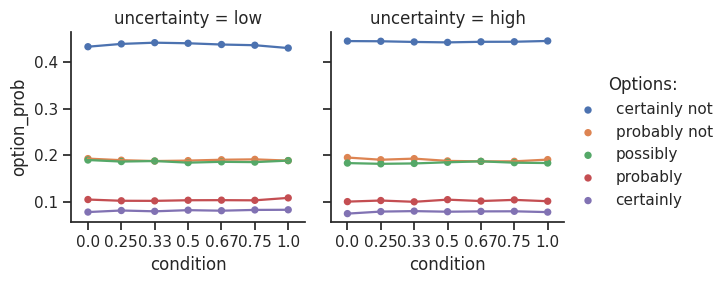

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", rc={"lines.linewidth": 0.9})
g = sns.FacetGrid(data=probs_base_1, col="uncertainty", hue="option", col_wrap=2)
g.map_dataframe(sns.pointplot, x="condition", y="option_prob")
g.add_legend(title="Options:")
#plt.legend(loc="upper right", bbox_to_anchor=(1, 1))
#plt.show()

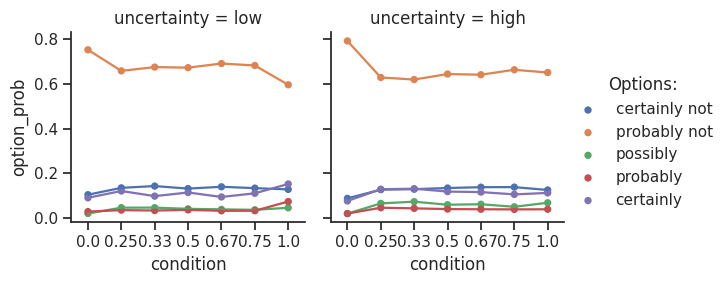

In [19]:
sns.set(style="ticks", rc={"lines.linewidth": 0.9})
g = sns.FacetGrid(data=probs_chat_1, col="uncertainty", hue="option", col_wrap=2)
g.map_dataframe(sns.pointplot, x="condition", y="option_prob", markers=["o", "s"])
g.add_legend(title="Options:")

Few Shots

In [20]:
probs_few_shots_base_1 = all_to_csv_1(model_base, tokenizer_base, few_shots=True)
probs_few_shots_base_1

,uncertainty,access,observation,condition,option,option_prob
0,low,10,0,0.0,certainly not,0.628132
1,low,10,0,0.0,probably not,0.145738
2,low,10,0,0.0,possibly,0.068842
3,low,10,0,0.0,probably,0.095578
4,low,10,0,0.0,certainly,0.061710
...,...,...,...,...,...,...
65,high,2,2,1.0,certainly not,0.626627
66,high,2,2,1.0,probably not,0.143135
67,high,2,2,1.0,possibly,0.070857
68,high,2,2,1.0,probably,0.096850


In [21]:
probs_few_shots_chat_1 = all_to_csv_1(model_chat, tokenizer_chat, few_shots=True, model_type="chat")
probs_few_shots_chat_1

,uncertainty,access,observation,condition,option,option_prob
0,low,10,0,0.0,certainly not,0.390062
1,low,10,0,0.0,probably not,0.006379
2,low,10,0,0.0,possibly,0.594773
3,low,10,0,0.0,probably,0.002205
4,low,10,0,0.0,certainly,0.006582
...,...,...,...,...,...,...
65,high,2,2,1.0,certainly not,0.272826
66,high,2,2,1.0,probably not,0.006416
67,high,2,2,1.0,possibly,0.713207
68,high,2,2,1.0,probably,0.001754


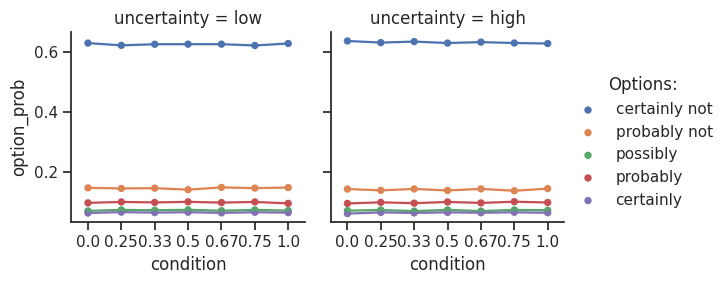

In [22]:
sns.set(style="ticks", rc={"lines.linewidth": 0.9})
g = sns.FacetGrid(data=probs_few_shots_base_1, col="uncertainty", hue="option", col_wrap=2)
g.map_dataframe(sns.pointplot, x="condition", y="option_prob", markers="o", linestyles=["-","--","+","~","-+"])
g.add_legend(title="Options:")

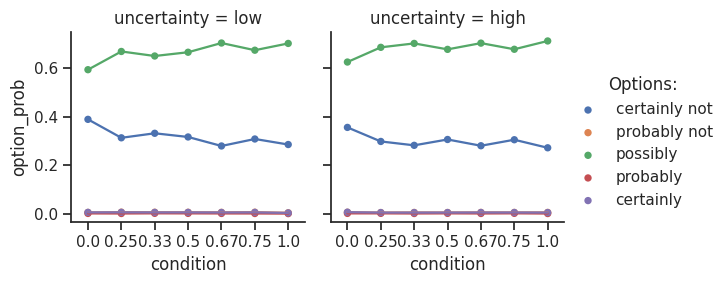

In [23]:
sns.set(style="ticks", rc={"lines.linewidth": 0.9})
g = sns.FacetGrid(data=probs_few_shots_chat_1, col="uncertainty", hue="option", col_wrap=2)
g.map_dataframe(sns.pointplot, x="condition", y="option_prob", markers="o", linestyles=["-","--","+","~","-+"])
g.add_legend(title="Options:")

In [24]:
prompt_math = """[INST] <<SYS>> 
You are an assistant good at counting. You only output the final answer without reasoning: 
<</SYS>>

Question: 10*1.5=
Answer: 
[/INST]
"""
get_option_probs(model_chat, tokenizer_chat, prompt_math, options=["15", "30", "20", "0", "a"])

{'15': 0.9474046712934568,
 '30': 0.03588390337979978,
 '20': 0.016687564830436527,
 '0': 1.1046422281474832e-05,
 'a': 1.2814074025259317e-05}

#### Model generation

In [25]:
def get_Ngenerated_answer_logprobs(model, tokenizer, prompt, n=100, choices=["A", "B", "C", "D", "E"]):
    tokenizer.pad_token_id = tokenizer.eos_token_id
    bad_words = [" ", "\n", "<s>", "</s>", "\\", "\n\n", "Answer"]
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    n_generated_answers = []
    for i in range(n):
        # Generate one token 
        with torch.no_grad():
            output = model.generate(
                **inputs,
                pad_token_id = tokenizer.eos_token_id,
                eos_token_id = tokenizer.eos_token_id,
                max_new_tokens=1,  # Generate only one token
                return_dict_in_generate=True,
                output_scores=True,
                temperature=1.0,
                top_k = 50,
                bad_words_ids=tokenizer(bad_words, add_special_tokens=False).input_ids
            )
        generated_token_id = output.sequences[0][-1].item()
        generated_token = tokenizer.decode(generated_token_id)
        #print(generated_token_id, generated_token)
        #print(tokenizer.decode(output.sequences[0]))
        # Compute log probabilities, take the first token because it should only generated one token
        #print("output score:", output.scores, output.scores[0].shape, inputs.input_ids.shape, len(prompt.split()))

        logits = output.scores[0][0]  # Shape: (vocab_size,)
        log_probs = torch.log_softmax(logits, dim=-1)  # Convert logits to log probabilities
        #print("log prob argmax:", torch.argmax(log_probs).item())
        #print("argmax token:", tokenizer.decode(torch.argmax(log_probs)))
        # Extract log probabilities for the generated token 
        answer_logprob = log_probs[generated_token_id].item()
        n_generated_answers.append((generated_token, answer_logprob))
            
    return n_generated_answers

In [26]:
generated_choices = get_Ngenerated_answer_logprobs(model_base, tokenizer_base, prompt_sample_base, n=1)
generated_choices

From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


[('B', -3.296546697616577)]

In [27]:
generated_choices_chat = get_Ngenerated_answer_logprobs(model_chat, tokenizer_chat, prompt_sample_chat, n=1)
generated_choices_chat

[('C', -3.22946834564209)]

In [28]:
generated_choices_few_shots = get_Ngenerated_answer_logprobs(model_base, tokenizer_base, prompt_few_shots_sample_base, n=1)
generated_choices_few_shots

[('The', -2.612328052520752)]

In [29]:
generated_choices_few_shots_chat = get_Ngenerated_answer_logprobs(model_chat, tokenizer_chat, prompt_few_shots_sample_chat, n=1)
generated_choices_few_shots_chat

[('Condition', -1.3774144649505615)]

In [30]:
def Ngenerated_to_csv(model, tokenizer, n=100, few_shots=False, model_type="base"):
    results = {"uncertainty":[], "access":[], "observation":[], "condition":[], "generated_answer":[], "generated_answer_logprob":[]}
    for access, observ in low:
        if not few_shots:
            prompt = context  + "\n\n" + question + "\n" + f"\nCondition: You draw {access} balls and observe {observ} of them are red. You put all balls back into the urn." + sent 
            if model_type == "chat":
                prompt = inst_b + " " + sys_b + "\n" + context  + "\n\n" + question + sys_e + "\n" + f"\nCondition: You draw {access} balls and observe {observ} of them are red. You put all balls back into the urn." + sent + inst_e + "\n"
        else:
            prompt = context_few_shots + "\n" + question_few_shots + sent_few_shots_1+f" You draw {access} balls and observe {observ} of them are red. You put all balls back to the urn." + sent_few_shots_2
            if model_type == "chat":
                prompt = inst_b + " " + sys_b + "\n"+ context_few_shots + "\n" + question_few_shots + sys_e +"\n"+ sent_few_shots_1+f" You draw {access} balls and observe {observ} of them are red. You put all balls back to the urn." + sent_few_shots_2 + inst_e +"\n"
        n_generated_answers = get_Ngenerated_answer_logprobs(model, tokenizer, prompt, n=n)
        for generated_token, token_logprob in n_generated_answers:
            if generated_token not in ["A", "B", "C", "D", "E"]:
                generated_token = "others"
            results["uncertainty"].append("low")
            results["access"].append(access)
            results["observation"].append(observ)
            results["condition"].append(str(round(observ/access, ndigits=2)))
            results["generated_answer"].append(expressions[generated_token])
            results["generated_answer_logprob"].append(token_logprob)

    for access, observ in high:
        if not few_shots:
            prompt = context  + "\n\n" + question + "\n" + f"\nCondition: You draw {access} balls and observe {observ} of them are red. You put all balls back into the urn." + sent 
            if model_type == "chat":
                prompt = inst_b + " " + sys_b + "\n" + context  + "\n\n" + question + sys_e + "\n" + f"\nCondition: You draw {access} balls and observe {observ} of them are red. You put all balls back into the urn." + sent + inst_e + "\n"
        else:
            prompt = context_few_shots + "\n" + question_few_shots + sent_few_shots_1+f" You draw {access} balls and observe {observ} of them are red. You put all balls back to the urn." + sent_few_shots_2
            if model_type == "chat":
                prompt = inst_b + " " + sys_b + "\n"+ context_few_shots + "\n" + question_few_shots + sys_e +"\n"+ sent_few_shots_1+f" You draw {access} balls and observe {observ} of them are red. You put all balls back to the urn." + sent_few_shots_2 + inst_e +"\n"
        n_generated_answers = get_Ngenerated_answer_logprobs(model, tokenizer, prompt, n=n)
        for generated_token, token_logprob in n_generated_answers:
            if generated_token not in ["A", "B", "C", "D", "E"]:
                generated_token = "others"
            results["uncertainty"].append("high")
            results["access"].append(access)
            results["observation"].append(observ)
            results["condition"].append(str(round(observ/access, ndigits=2)))
            results["generated_answer"].append(expressions[generated_token])
            results["generated_answer_logprob"].append(token_logprob)


    results_df = pd.DataFrame.from_dict(results)
    shot = "zero-shot"
    if few_shots:
        shot = "few-shots"
    results_df.to_csv(f"generated_answer_logprobs_{model_type}_{shot}.csv", encoding="utf-8")
    return results_df 

In [31]:
base_ngenerated_df = Ngenerated_to_csv(model_base, tokenizer_base)
base_ngenerated_df

,uncertainty,access,observation,condition,generated_answer,generated_answer_logprob
0,low,10,0,0.0,others,-2.714986
1,low,10,0,0.0,others,-3.543111
2,low,10,0,0.0,possibly,-3.089986
3,low,10,0,0.0,probably not,-3.074361
4,low,10,0,0.0,others,-0.722799
...,...,...,...,...,...,...
1395,high,2,2,1.0,others,-0.704995
1396,high,2,2,1.0,others,-0.704995
1397,high,2,2,1.0,others,-0.704995
1398,high,2,2,1.0,certainly not,-2.236245


In [32]:
chat_ngenerated_df = Ngenerated_to_csv(model_chat, tokenizer_chat,model_type="chat")
chat_ngenerated_df

,uncertainty,access,observation,condition,generated_answer,generated_answer_logprob
0,low,10,0,0.0,certainly,-2.470295
1,low,10,0,0.0,probably not,-0.376545
2,low,10,0,0.0,certainly,-2.470295
3,low,10,0,0.0,probably not,-0.376545
4,low,10,0,0.0,probably not,-0.376545
...,...,...,...,...,...,...
1395,high,2,2,1.0,possibly,-2.908643
1396,high,2,2,1.0,others,-2.197706
1397,high,2,2,1.0,others,-2.197706
1398,high,2,2,1.0,probably not,-0.666456


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


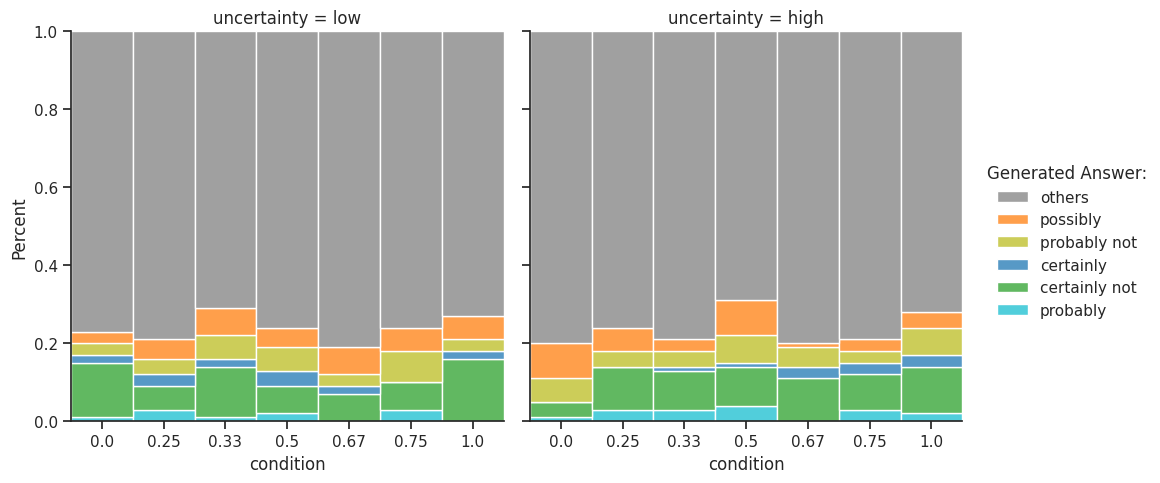

In [33]:
base_ngenerated_df.condition= base_ngenerated_df['condition'].astype(str)
g=sns.displot(data=base_ngenerated_df, col="uncertainty", x="condition", multiple="fill", hue="generated_answer", stat="percent", palette={"certainly not":"tab:green", "probably not":"tab:olive", "possibly":"tab:orange", "probably":"tab:cyan", "certainly":"tab:blue", "others":"grey"})
g._legend.set_title("Generated Answer:")

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


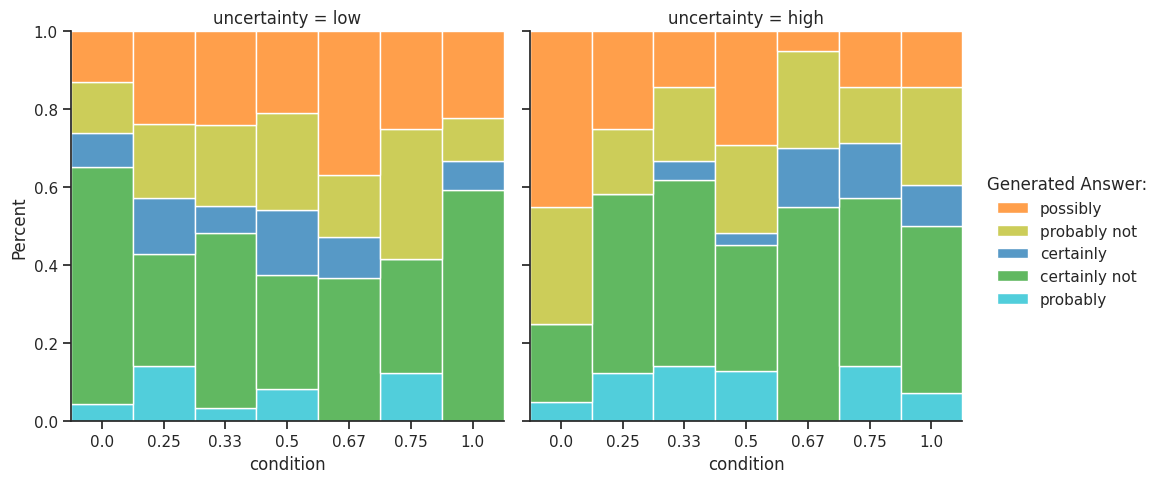

In [42]:
base_df_not_others = base_ngenerated_df[base_ngenerated_df["generated_answer"] != "others"]
g=sns.displot(data=base_df_not_others, col="uncertainty", x="condition", multiple="fill", hue="generated_answer", stat="percent", palette={"certainly not":"tab:green", "probably not":"tab:olive", "possibly":"tab:orange", "probably":"tab:cyan", "certainly":"tab:blue", "others":"grey"})
g._legend.set_title("Generated Answer:")

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


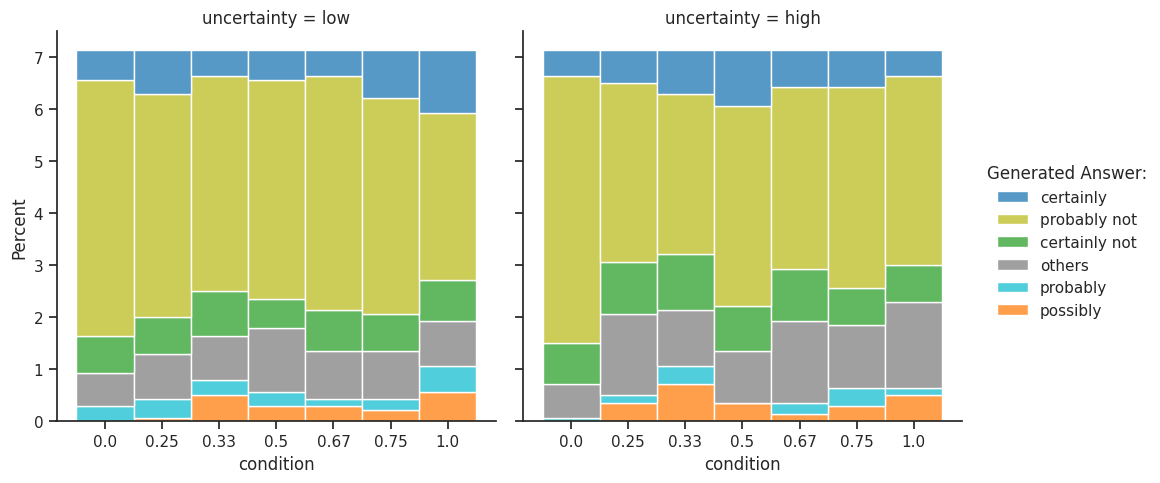

In [35]:
chat_ngenerated_df.condition= chat_ngenerated_df['condition'].astype(str)
g=sns.displot(data=chat_ngenerated_df, col="uncertainty", x="condition", multiple="stack", hue="generated_answer", stat="percent", palette={"certainly not":"tab:green", "probably not":"tab:olive", "possibly":"tab:orange", "probably":"tab:cyan", "certainly":"tab:blue", "others":"grey"})
g._legend.set_title("Generated Answer:")

#### Few shots 

In [36]:
base_ngenerated_few_shots_df = Ngenerated_to_csv(model_base, tokenizer_base,few_shots=True)
base_ngenerated_few_shots_df

,uncertainty,access,observation,condition,generated_answer,generated_answer_logprob
0,low,10,0,0.0,others,-3.778285
1,low,10,0,0.0,others,-3.059535
2,low,10,0,0.0,others,-1.426722
3,low,10,0,0.0,others,-4.122035
4,low,10,0,0.0,others,-2.653285
...,...,...,...,...,...,...
1395,high,2,2,1.0,certainly not,-2.469184
1396,high,2,2,1.0,others,-2.547309
1397,high,2,2,1.0,certainly not,-2.469184
1398,high,2,2,1.0,others,-3.008247


In [37]:
chat_ngenerated_few_shots_df = Ngenerated_to_csv(model_chat, tokenizer_chat,few_shots=True, model_type="chat")
chat_ngenerated_few_shots_df

,uncertainty,access,observation,condition,generated_answer,generated_answer_logprob
0,low,10,0,0.0,others,-0.522137
1,low,10,0,0.0,others,-1.194012
2,low,10,0,0.0,others,-3.334637
3,low,10,0,0.0,others,-1.194012
4,low,10,0,0.0,others,-1.194012
...,...,...,...,...,...,...
1395,high,2,2,1.0,others,-0.295744
1396,high,2,2,1.0,others,-0.295744
1397,high,2,2,1.0,others,-0.295744
1398,high,2,2,1.0,others,-1.639494


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


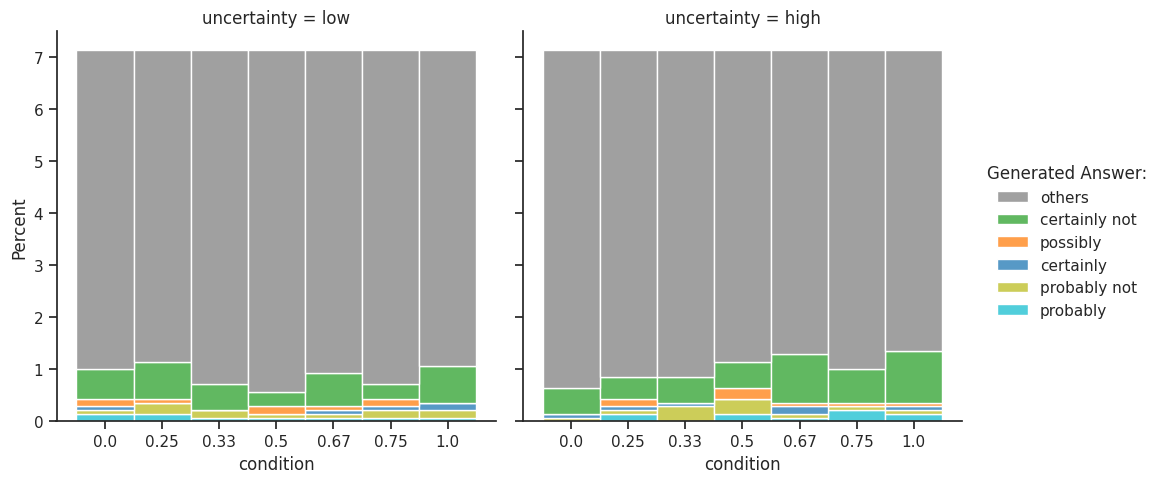

In [43]:
g=sns.displot(data=base_ngenerated_few_shots_df, col="uncertainty", x="condition", multiple="stack", hue="generated_answer", stat="percent", palette={"certainly not":"tab:green", "probably not":"tab:olive", "possibly":"tab:orange", "probably":"tab:cyan", "certainly":"tab:blue", "others":"grey"})
g._legend.set_title("Generated Answer:")

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


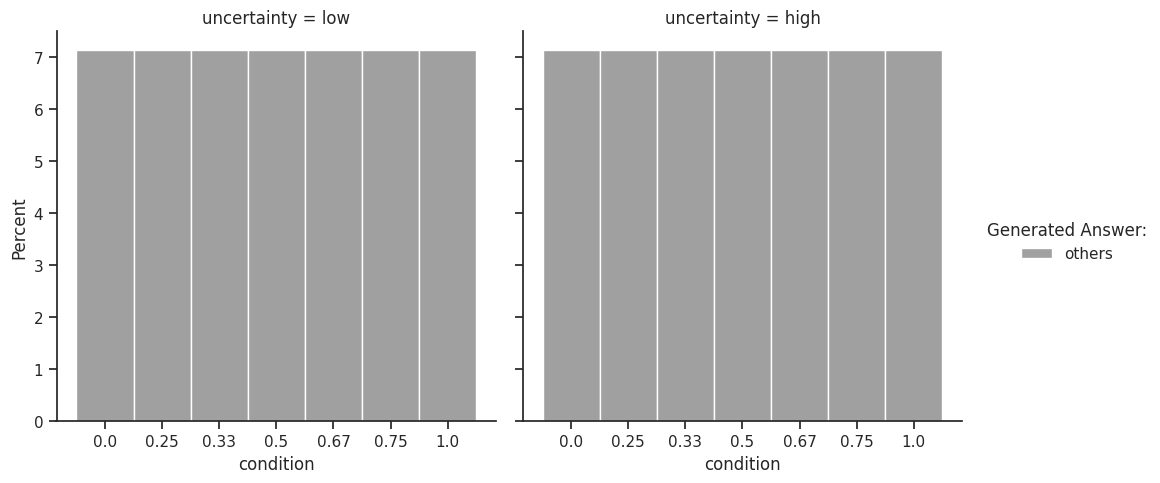

In [44]:
g=sns.displot(data=chat_ngenerated_few_shots_df, col="uncertainty", x="condition", multiple="stack", hue="generated_answer", stat="percent", palette={"certainly not":"tab:green", "probably not":"tab:olive", "possibly":"tab:orange", "probably":"tab:cyan", "certainly":"tab:blue", "others":"grey"})
g._legend.set_title("Generated Answer:")

In [40]:
%cd /kaggle/working

/kaggle/working


In [41]:
from IPython.display import FileLink 
FileLink(r'generated_answer_logprobs_chat_few-shots.csv')

/kaggle/working/generated_answer_logprobs_chat_few-shots.csv